### Phys 453: Quantum Mechanics - Kronig Penney Model
One of the most technologically useful applications of quantum mechanics is the **band theory of solids**.  A fundamental result of band theory is that when an electron is trapped in a periodic potential, the allowable energies form (almost) continuous bands, separated from one another by finite energy gaps - called **band gaps**. The formation of these bands and the locations of band gaps determine the material properties of many crystals.  For example, band theory provides a quantum explanation of the difference between metals and insulators, as well as an understanding of the properties of semi-conductors like silicon.  Band theory is also the fundamental method of understanding how transistors work, making it one of the scientific principles under-girding much of modern (technological) civilization.

In this notebook, we'll explore the Kronig Penney Model, a toy model that provides a good laboratory to start understanding the properties of real materials.  The Kronig Penney Model is actually super simple - it's just a periodic potential of finite square wells, each of width $a$, separated by potential walls of height $V_0$ and width $b$.  (The idea is that this is a very crude model of the periodic Coulomb potential felt by electrons from nuclei in a crystal.) This model can actually be partially solved analytically, but it's pretty messy and you still can't get some interesting properties out, like the full band structure, $E_n(k)$ or the density of states, $D(E)$.

In the additional notes that go along with this notebook (see Canvas), it is shown how to find the wavefunctions in each part of potential and then use **Bloch's Theorem** (see Section 5.3.2 in Griffiths and lecture on Monday March 12) and the relevant boundary conditions to obtain a system of 4 equations in 4 unknowns that determine the allowable states, labeled by crystal momentum $k$ and energy $E$.  In order to find an equation for these solutions, you would need to take the determinant of a 4 by 4 matrix, which is doable by hand but unpleasant.  Let's call $M(E,k)$ the 4 by 4 matrix that we get from applying the boundary conditions, which has input parameter $k$ and $E$.  Then the allowed states obey the equation
$$det[M(E,k)]=0$$
No one actually wants to do this by hand, and in any case the analytic answer is not very enlightening.  So instead, let's figure out how to numerically find pairs $(k,E)$ that satisfy the above equation.  In order to save some space, let's define a function, $f(E,k)=det[M(E,k)]$. Our goal then is to find the **roots** of $f(E,k)$, where $f(E,k)=0$.

Here's a specific algorithm for finding the right pairs $(k,E)$.  For each value of $k$ that you care about, calculate $f(E,k)$ for a range of energies in which you think the physical solutions lie. Luckily, we have physical intuition for what this energy range must be - all bound state energies must be between $0$ and $V_0$.  If we are careful about it, we can find all the bound state energies, $E_n(k)$, that go with a particular $k$.  Notice that I labeled the different energies with an index $n$ - this is called the **band index**, and tells you which band each energy belongs to.  This will probably make more sense when we actually plot the band structure, but the important point is that there are multiple allowed energies for each value of $k$.

Once we can calculate $E_n(k)$ for a particular $k$, we can obtain all the possible states by scanning over $k$ in some range, which turns out to be $k\in[0,\pi/c]$, where $c=a+b$.  (That's the first **Brillouin Zone** for the model - any $k$ outside of this range just gives repeats of the same states.) Putting this all together allows us to find the full **band structure** for the model, and ultimately calculate the density of states and the band gap energies.



### Setup
That sounds like a lot of stuff to do! But it won't be that bad :-)  Here are the libraries we'll need.  We're also going to work with $\hbar=m=1$, and $a=2$, $b=0.2$, and $V_0=10$.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize   #Contains brentq, the root finding algorithm we'll use

<IPython.core.display.Javascript object>


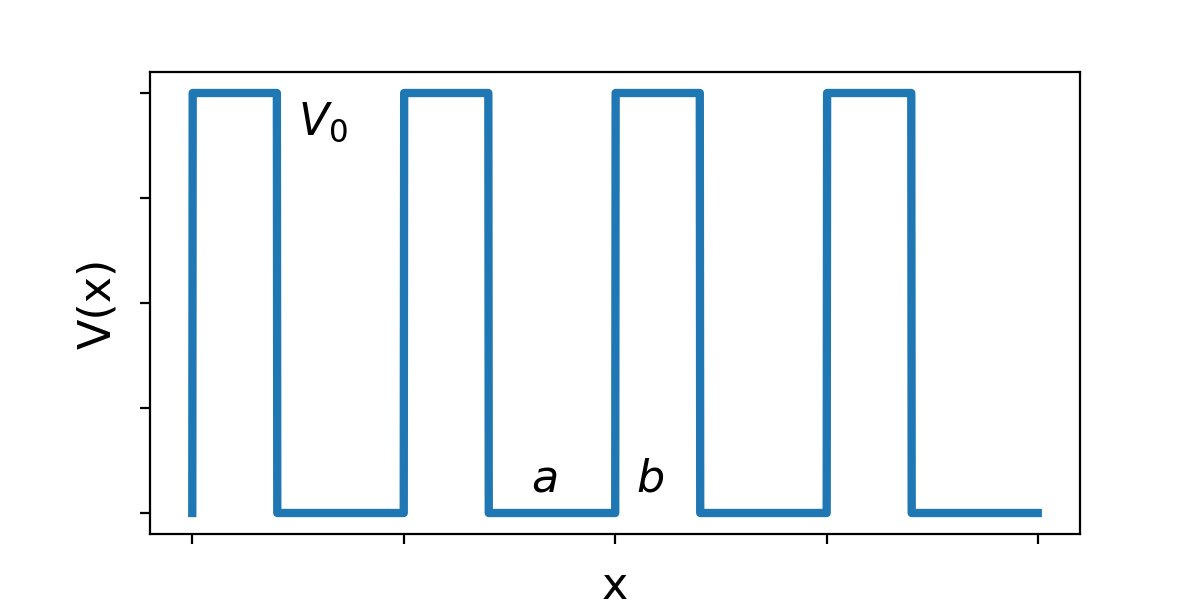

In [61]:
fig, ax = plt.subplots(figsize=(6,3))
#ax = plt.add_subplot(1,1,1)

x = np.arange(-10,10,0.01)
y = np.zeros_like(x)

mask = [False]*len(x)
x_tar = -10
while x_tar < 10:
    mask = mask | ((x > x_tar) & (x < x_tar+2))
    x_tar += 5

y[mask]=1

plt.plot(x,y,lw=3)
ax.set_ylabel('V(x)')
ax.set_xlabel('x')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.text(-2,0.05,r'$a$')
ax.text(0.5,0.05,r'$b$')
ax.text(-7.5,0.9,r'$V_0$')

plt.show()

In [5]:
plt.rc('font', size=16)
plt.rc('legend', fontsize=12)

V0=10
m=1
hbar=1
a=2
b=0.2

### Question 1: Calculating the determinant

<font color='orange'>ALERT! Refer to the additional notes on Canvas to start this question! </font>

Finish the following function to calculate the determinant of the matrix you get from applying the boundary conditions.  It should be a 4 by 4 matrix.  Note that we return the real part of the determinant - in general the determinant is a complex number, but we only care about finding where the determinant is equal to zero.  If the determinant is equal to zero, then both its real and imaginary parts must also be equal to zero, so we can use either part in the root finding algorithm. (In this case, the real and imaginary parts are always zero in the same places - you can check that by plotting the imaginary part, if you like.)

In [9]:
def KP_determinant(E,k):
    alpha=np.sqrt(2*m*E)/hbar
    beta=np.sqrt(2*m*(V0-E))/hbar
    #Fill in the matrix you get from applying boundary conditions
    mat_equ = np.array(
    [
            [1,1,-1,-1],
            [1j*alpha,-1j*alpha,-beta,beta],
            [np.exp(1j*(alpha-k)*a),np.exp(-1j*(alpha+k)*a),-np.exp(-(beta-1j*k)*b),-np.exp((beta+1j*k)*b)],
            [1j*(alpha-k)*np.exp(1j*(alpha-k)*a),-1j*(alpha+k)*np.exp(-1j*(alpha+k)*a),-(beta-1j*k)*np.exp(-(beta-1j*k)*b),(beta+1j*k)*np.exp((beta+1j*k)*b)]
        ]
    )
    return np.linalg.det(mat_equ).real

### Checking the determinant
The below graph provides a chance to check your determinant code.  It plots $det[M(E,k)]$ vs $E$ for $k=0.41$.  The bound state energies for $k=0.41$ should be approximately $E=0.6,3.6,6.4$, so at this $k$ point it looks like there will be 3 bands.

<IPython.core.display.Javascript object>


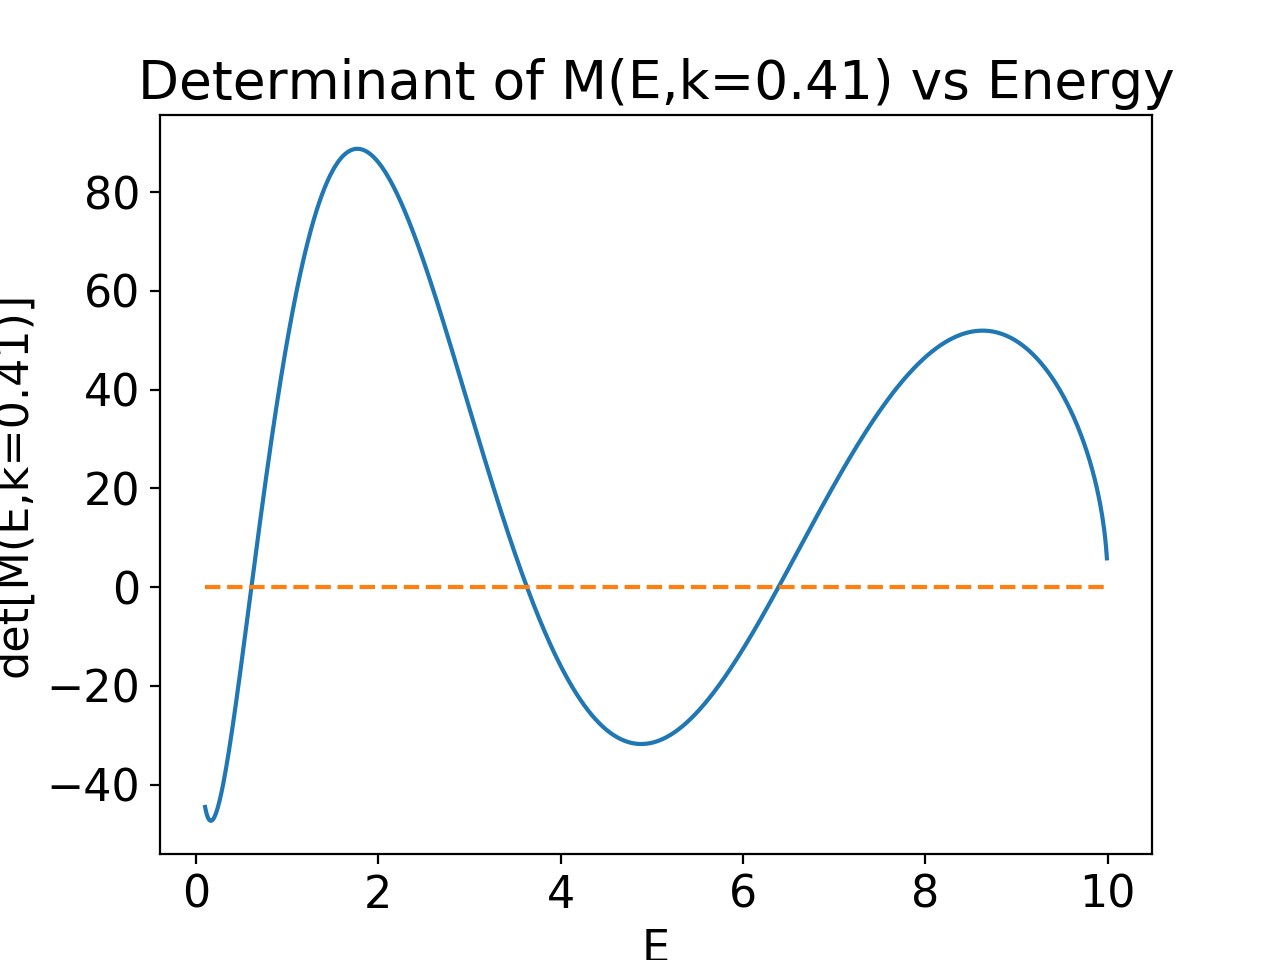

In [10]:
test_k=0.41
Es = np.arange(0.1,V0,0.01)
KP_dets = np.zeros_like(Es)
for i in range(0, len(Es)):
    KP_dets[i] = KP_determinant( Es[i], test_k)
    
plt.figure()
plt.plot(Es, KP_dets)
plt.plot(Es, np.zeros_like(Es),'--')
plt.xlabel('E')
plt.ylabel("det[M(E,k=0.41)]")
plt.title("Determinant of M(E,k=0.41) vs Energy")
plt.savefig("DetM_vs_E.png")
plt.show()

### Question 2: Root Finding
Now that we have the value of the determinant for a bunch of different energies at a particular $k$, we need to find the precise $E$ at which $det[M(E,k)]=0$.  We'll do this in two steps - first we'll find pairs of energies, $(E_1,E_2)$, between which we know there is a root because $det[M(E,k)]$ changes sign. ($(E_1,E_2)$ is called a sign changing interval.)  With these rough energy windows, we'll then use the [brentq](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.brentq.html) algorithm to precisely locate the bound state energies.

Finish these two functions. `find_zero_crossings` should take an array of energies and a value of $k$ as arguments and then return all the sign changing intervals in the form of a list of pairs. `acquire_energies` should take these sign changing intervals and use the `brentq` method to calculate the exact root for each interval.

In [11]:
def find_zero_crossings(energy_range, k):
    zeros_list=[]  #Add energy pairs to list list if we think there is a zero in between them
    value = KP_determinant(energy_range[0], k)  #Get the starting value of boundary_function
    
    for i in range(0, len(energy_range)-1):
        new_value = KP_determinant(energy_range[i+1], k)
        #If we crossed through a zero, save this pair of energies.  Fix the next two lines to do this
        if(np.sign(new_value)*np.sign(value) == -1):
            zeros_list.append((energy_range[i], energy_range[i+1]))
        value = new_value
    return zeros_list

def acquire_energies(energy_bounds, k):
    energies = []
    for energy_bound in energy_bounds:
        #On the next line, what should the arguments of brentq be?
        energies.append( scipy.optimize.brentq(KP_determinant, energy_bound[0], energy_bound[1], k) ) 
    return energies

### Check the root finding
The below code checks your root finding functions. It should find that the bound state energies for $k=0.41$ are about $E=0.60795, 3.62998, 6.3881$.

In [12]:
energy_bounds = find_zero_crossings(Es, test_k)
print('Sign Changing Intervals = ',energy_bounds)
energies = acquire_energies(energy_bounds, test_k)
print('Exact Bound State Energies = ',energies)

Sign Changing Intervals =  [(0.59999999999999976, 0.60999999999999976), (3.6199999999999983, 3.6299999999999981), (6.3799999999999963, 6.3899999999999961)]
Exact Bound State Energies =  [0.6079541638413559, 3.629982008315435, 6.388130898610957]


### Question 3: Calculate the Band Structure
Okay, now we're going to calculate the full band structure - we'll calculate the allowed energies for every $k\in[0, \pi/c)$.  Here's a bit of setup.  Note that I'm cheating a little bit here - I've picked the parameters of the model so that there will be 3 bands.

In [13]:
ks=np.arange(0.01, np.pi/(a*(1+1.*b/a)), 0.05)
Es = np.arange(0.01,V0,0.01)
first_band = np.zeros_like(ks)   #Lowest energy for each k
second_band = np.zeros_like(ks)  #First excited energy for each k
third_band = np.zeros_like(ks)   #Second excited energy for each k

Here's your part. Write some code that will loop through my `ks` array and calculate the bound state energies.  Fill in the `first_band`, `second_band`, and `third_band` energies.

In [14]:
# Calculate the energies for each k and fill in the *_band arrays
for i in range(0,len(ks)):
    energy_bounds = find_zero_crossings(Es, ks[i])
    energies = acquire_energies(energy_bounds, ks[i])

    first_band[i] = energies[0]
    second_band[i] = energies[1]
    third_band[i] = energies[2]

### Question 4: Plotting the Band Structure
The below code plots your band structure, or the collection of all values of $E$ and $k$ a particle in this system can have.  What are the approximate values of the band gaps? (Remember - the band gap is the smallest energy difference (for any value of $k$) between two bands.) Suppose an electron is in the first band.  If a photon with $E_\gamma=3$ excites the electron into the second band, what must be the value of $k$ for the electron? (Remember that photons carry very little momentum!)

<IPython.core.display.Javascript object>


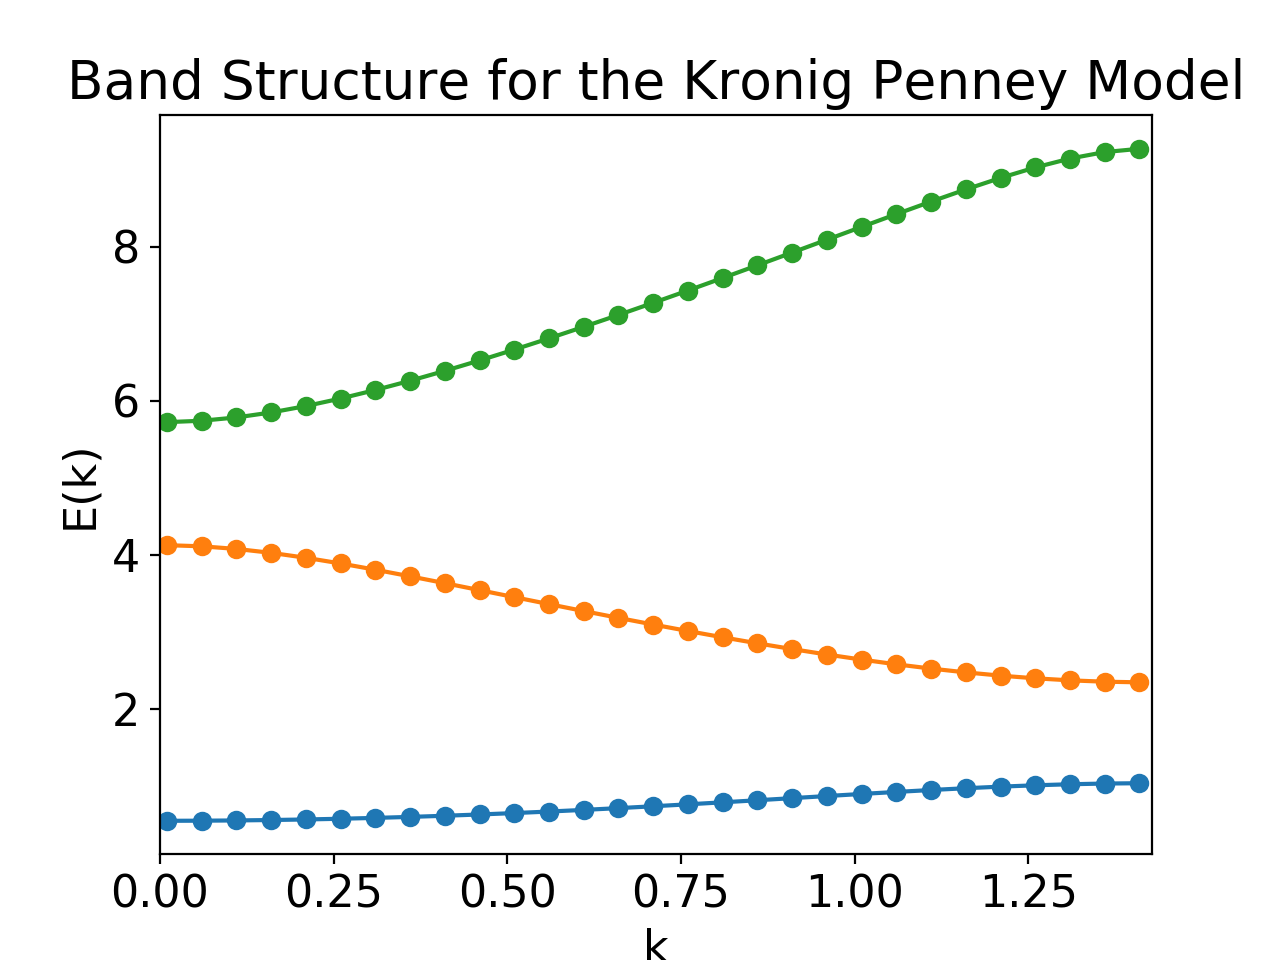

In [15]:
plt.figure()
plt.plot(ks, first_band,'-o')
plt.plot(ks, second_band,'-o')
plt.plot(ks, third_band,'-o')
plt.xlabel('k')
plt.ylabel('E(k)')
plt.xlim([0,np.pi/(a*(1+1.*b/a))])
plt.title('Band Structure for the Kronig Penney Model')
plt.savefig("KP_Band_Structure.png")
plt.show()

**Write your answer to Question 4 here**

The band gap between bands 1 and 2 occurs around $k=1.4$, and the band gap energy is about 1. The band gap between bands 2 and 3 occurs at $k=0$, and the band gap energy is about 1.75. For the photon driven transition, the wave vector must be around $k=0.4$.  This is where a photon with $E_\gamma=3$ can provide the right amount of energy to move an electron from the first band to the second band.

### Question 5: Density of States
Okay, you're done coding! But there's one more question you'll have to answer.  The code below uses your band structure data to calculate the density of states, $D(E)$.  For 1-dimensional models, the density of states is given by:
$$D(E)=\frac{2}{\pi}\frac{dk}{dE}$$
This formula may seem foreign, but the interpretation of the density of states is pretty simple - $D(E)$ is large if there are lots of states between $E$ and $E+\delta E$, and small if there a few states in that energy range.   It tells you how many states exist at each energy.

For the energy bands of the Kronig Penney Model, where is the density of states largest?  How do band gaps appear in this representation of the system?  (A band gap occurs at energies where there are no allowable states.)  If every state up until $E=3$ were occupied, would the system be a metal or an insulator?

<IPython.core.display.Javascript object>


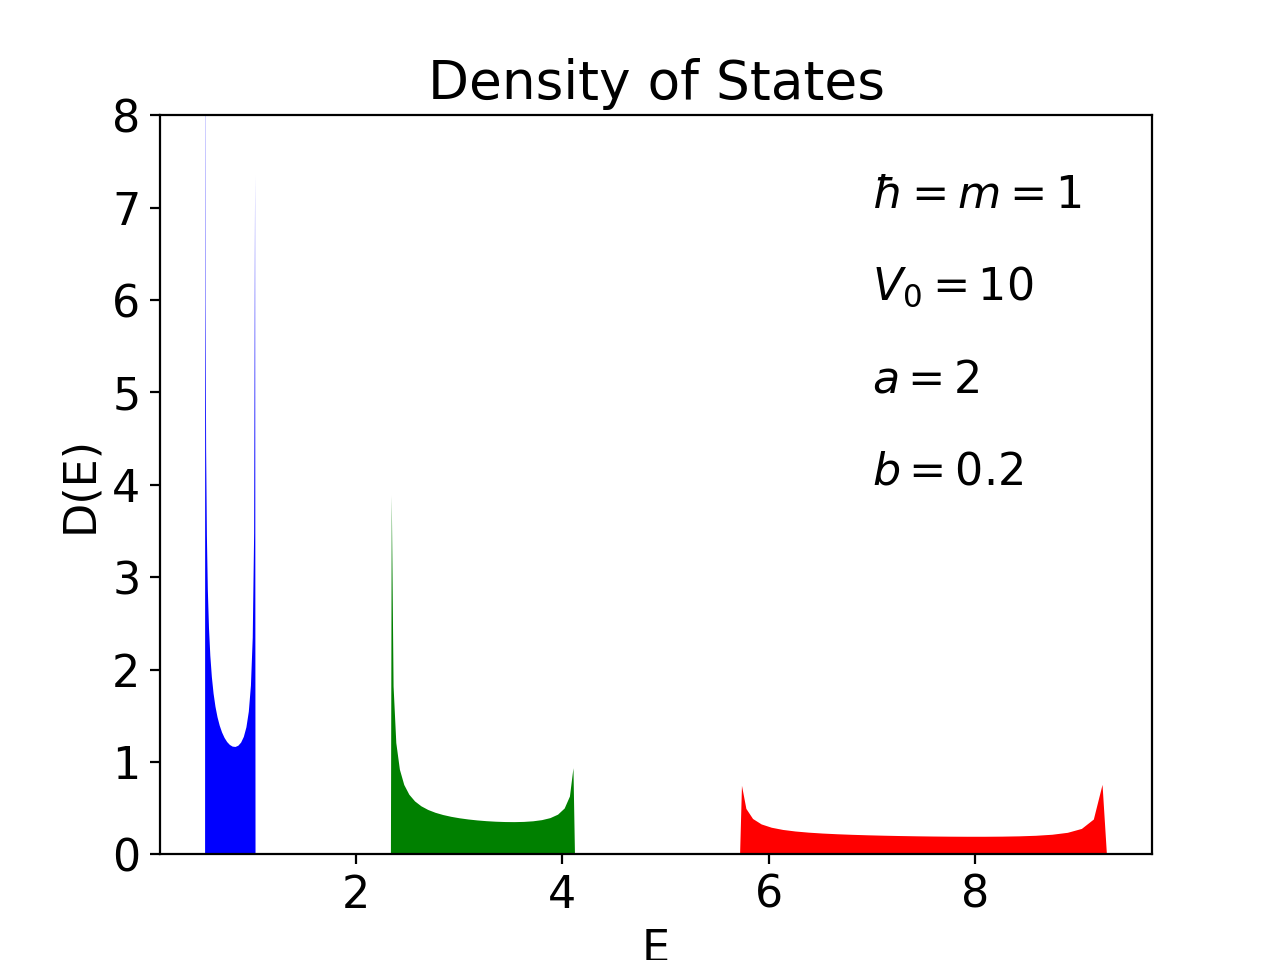

In [16]:
density_states_first_band = np.zeros_like(first_band)

for i in range(0, len(first_band)-1):
    density_states_first_band[i] = 2./np.pi*(ks[i+1]-ks[i])/(first_band[i+1]-first_band[i])
density_states_first_band[0] = 0
    
density_states_second_band = np.zeros_like(second_band)

for i in range(0, len(second_band)-1):
    density_states_second_band[i] = -2./np.pi*(ks[i+1]-ks[i])/(second_band[i+1]-second_band[i])
density_states_second_band[0] = 0
    
density_states_third_band = np.zeros_like(third_band)

for i in range(0, len(third_band)-1):
    density_states_third_band[i] = 2./np.pi*(ks[i+1]-ks[i])/(third_band[i+1]-third_band[i])
density_states_third_band[0] = 0
    
plt.figure()

plt.fill_between(first_band, np.zeros_like(first_band), density_states_first_band, facecolor='blue')
plt.fill_between(second_band, np.zeros_like(second_band), density_states_second_band, facecolor='green')
plt.fill_between(third_band, np.zeros_like(third_band), density_states_third_band, facecolor='red')

plt.ylim([0,8])
plt.xlabel('E')
plt.ylabel('D(E)')
plt.title('Density of States')

plt.text(7,7,r'$\hbar=m=$'+str(1))
plt.text(7,6,r'$V_0=$'+str(V0))
plt.text(7,5,r'$a=$'+str(a))
plt.text(7,4,r'$b=$'+str(b))
plt.savefig("KP_Density_Of_States.png")
plt.show()

**Answer Question 5 here**

The density of states is largest near the edges of the bands.  The band gaps appear as areas where there are no states, so that the density of states is zero, $D(E)=0$. If the system were filled up to $E=3$, then the highest energy electon could move into an empty state with an arbitrarily small amount of energy. (Since it would be right in the middle of the second band.)  Thus, it is easy for a electron to "move around", so the system would be a metal.